In [20]:
from __future__ import print_function
import torch
import numpy as np

In [21]:
# 关于数据
# 通常，当你处理图像，文本，音频和视频数据时，你可以使用标准的Python包来加载数据到一
# 个numpy数组中.然后把这个数组转换成torch.*Tensor 。
# 对于图像,有诸如Pillow,OpenCV包等非常实用
# 对于音频,有诸如scipy和librosa包
# 对于文本,可以用原始Python和Cython来加载,或者使用NLTK和SpaCy 对于视觉,我们创建了
# 一个torchvision 包,包含常见数据集的数据加载,比如Imagenet,CIFAR10,MNIST等,和图像
# 转换器,也就是torchvision.datasets 和torch.utils.data.DataLoader 。
# 这提供了巨大的便利,也避免了代码的重复。

# 在这个教程中,我们使用CIFAR10数据集,它有如下10个类
# 别:’airplane’,’automobile’,’bird’,’cat’,’deer’,’dog’,’frog’,’horse’,’ship’,’truck’。这个数据集中的图像大
# 小为3*32*32,即,3通道,32*32像素。

In [22]:
# 训练一个图像分类器
# 我们将按照下列顺序进行:
# 使用torchvision 加载和归一化CIFAR10训练集和测试集.
# 定义一个卷积神经网络
# 定义损失函数
# 在训练集上训练网络
# 在测试集上测试网络

In [35]:
# 1. 加载和归一化CIFAR10(使用torchvision)
import torchvision
import torchvision.transforms as transforms

# torchvision的输出是[0,1]的PILImage图像,我们把它转换为归一化范围为[-1, 1]的张量。
transoform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

NameError: ignored

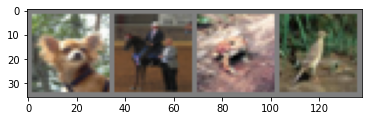

  doghorse frog bird


In [36]:
import matplotlib.pyplot as plt

# function to show an image
def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print(''.join('%5s' % classes[labels[j]] for j in range(4)))

In [37]:
# 定义一个卷积网络
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
net = Net()

In [38]:
# 定义损失函数和优化器
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [39]:
# 训练网络
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data # get the inputs
    optimizer.zero_grad() # zero the parameter gradients
    # forward + backward + optimizer
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
print('Finished Training')


[1,  2000] loss: 2.201
[1,  4000] loss: 1.932
[1,  6000] loss: 1.672
[1,  8000] loss: 1.578
[1, 10000] loss: 1.496
[1, 12000] loss: 1.461
[2,  2000] loss: 1.389
[2,  4000] loss: 1.357
[2,  6000] loss: 1.344
[2,  8000] loss: 1.310
[2, 10000] loss: 1.313
[2, 12000] loss: 1.299
Finished Training


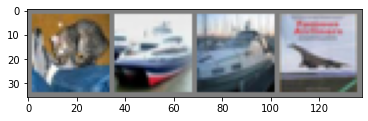

tensor([3, 8, 8, 0])
GroundTruth:    cat  ship  ship plane


In [40]:
# 在测试集上测试数据
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(labels)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [41]:
outputs = net(images)
# 输出是10个标签的概率。一个类别的概率越大,神经网络越认为他是这个类别。所以让我们得到
# 最高概率的标签。
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
for j in range(4)))

Predicted:    cat  ship  ship plane


In [42]:
# 查看在测试数据集上的整体效果
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
  100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [43]:
# 查看各个类的预测结果
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
  for i in range(4):
    label = labels[i]
    class_correct[label] += c[i].item()
    class_total[label] += 1
    
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
  classes[i], 100 * class_correct[i] / class_total[i]))

ZeroDivisionError: ignored

In [ ]:
# 在GPU上使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
#假设我们有一台CUDA的机器，这个操作将显示CUDA设备。
print(device)
# 这些方法将递归遍历所有模块并将其参数和缓冲区转换为CUDA张量：
net.to(device)
# 请记住，你也必须在每一步中把你的输入和目标值转换到GPU上:
inputs, labels = inputs.to(device), labels.to(device)